# Renault car sequencing II -- greedy

https://www.roadef.org/challenge/2005/en/


Es werden fünf Pakete importiert. 
<ul>
    <li><code>pandas</code>: Manipulation von Tabellendaten</li>
    <li><code>numpy</code>: wissenschaftliche Bibliothek, im wesentlichen für die array-Klasse</li>
    <li><code>matplotlib</code>: Visualisierung</li>
    <li><code>os</code>: Systemzugriffen, insbesondere Navigation des Dateisystems</li>
    <li><code>re</code>: regular expressions</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import math
import random

In [2]:
#path="../RENAULT/Instances_set_A/"   # Pfad zu den gespeicherten Instanzen -- ersetzen Sie das durch den entsprechenden Pfad bei Ihnen

!wget https://www.roadef.org/challenge/2005/files/Instances_set_A.zip
!unzip Instances_set_A.zip
path="Instances/"

## Methoden zum Einlesen aller Instanzen

Alle Instanzen unter path werden in ein dictionary eingelesen <code>data_dict</code>.

In [3]:
class Vehicle:
    def __init__(self,ident,colour,options):
        self.ident=ident
        self.colour=colour
        self.options=options
        
    def __repr__(self):
        return str(self.ident)
    
    def __str__(self):
        return "id: {}, Farbe: {}, Optionen: {}".format(self.ident,self.colour,self.options)

def get_weights(opt_objectives):
    weights={'paint':0, 'high':0, 'low':0}
    w=[1000000,1000,1]
    for i,row in opt_objectives.iterrows():
        key=re.match(r"([a-z]+)_",row['objective name']).group(1)
        weights[key]=w[row['rank']-1]
    return weights
    
def read_objectives(filepath):
    opt_objectives=pd.read_csv(filepath,sep=';')
    opt_objectives=opt_objectives.drop(columns="Unnamed: 2")
    return get_weights(opt_objectives)
    
def parse_paint_batch_limit(filepath):
    paint_batch_limit_csv=pd.read_csv(filepath,sep=';')
    paint_batch_limit=paint_batch_limit_csv.loc[0,'limitation']
    return paint_batch_limit    

def read_ratios(filepath):
    ratios_table=pd.read_csv(filepath,sep=';')
    ratios_table['p']=ratios_table["Ratio"].str.extract(r"(\d*)/").astype('int')
    ratios_table['q']=ratios_table["Ratio"].str.extract(r"/(\d*)").astype('int')
    ratios_table=ratios_table.drop(columns=['Unnamed: 3'])
    #ratios_table=ratios_table.set_index('Ident')
    ratios={}
    for i,row in ratios_table.iterrows():
        ratios[row['Ident']]=(row['p'],row['q'])
    return ratios

def process_vehicles(vehicles):
    previous_day_vehicles=[]
    current_day_vehicles=[]
    for i,row in vehicles.iterrows():
        options=[option for option in row[4:-1].index if row[option]==1]
        car=Vehicle(row["Ident"],row['Paint Color'],options)
        if row['already scheduled']:
            previous_day_vehicles.append(car)
        else:
            current_day_vehicles.append(car)
    return previous_day_vehicles,current_day_vehicles

def read_vehicles(filepath):
    vehicles=pd.read_csv(filepath,sep=';')
    previous_day=vehicles['Date'].iloc[0]
    vehicles["already scheduled"]=vehicles['Date']==previous_day
    return vehicles

def get_renault_schedule(vehicles):
    """
    Die Reihung des Renault-Algorithmus
    """
    renault_schedule=list(vehicles.loc[vehicles['already scheduled']==False,'Ident'])
    return renault_schedule

def read_in_all_instances(path,silent=False):
    data_dict={}
    for root, dirs, files in os.walk(path):
        instance_dict={}
        rest,first=os.path.split(root)
        data_dict[first]=instance_dict
        for filename in files:
            filepath=os.path.join(root,filename)
            if filename=="optimization_objectives.txt":
                opt_obj=read_objectives(filepath)
                instance_dict["weights"]=opt_obj            
            if filename=="paint_batch_limit.txt":
                paint_batch_limit=parse_paint_batch_limit(filepath)
                instance_dict['paint_batch_limit']=paint_batch_limit
            if filename=="ratios.txt":
                ratios=read_ratios(filepath)
                instance_dict["ratios"]=ratios            
            if filename=="vehicles.txt":
                vehicles=read_vehicles(filepath)
                previous,current=process_vehicles(vehicles)
                instance_dict["previous_day"]=previous
                instance_dict["current_day"]=current
                instance_dict["renault_schedule"]=current.copy()
    delete=[]
    for key in data_dict.keys():
        if data_dict[key]=={}:
            delete.append(key)
        data_dict[key]['name']=key
    for key in delete:
        del data_dict[key]
    if not silent:
        print("Folgende Instanzen wurden eingelesen: ")
        for key in data_dict.keys():
            print("  "+key)
    return data_dict

from operator import itemgetter
def prio_string(instance):
    prio=[what for what,weight in sorted(instance['weights'].items(),key=itemgetter(1),reverse=True)]
    return "{} >> {} >> {}".format(prio[0],prio[1],prio[2])

In [4]:
data_dict=read_in_all_instances(path)

Folgende Instanzen wurden eingelesen: 
  039_38_4_EP_RAF_ch1
  024_38_3_EP_ENP_RAF
  048_39_1_EP_ENP_RAF
  025_38_1_EP_ENP_RAF
  064_38_2_EP_RAF_ENP_ch1
  064_38_2_RAF_EP_ENP_ch2
  022_3_4_EP_RAF_ENP
  048_39_1_EP_RAF_ENP
  024_38_5_EP_RAF_ENP
  039_38_4_RAF_EP_ch1
  024_38_3_EP_RAF_ENP
  025_38_1_EP_RAF_ENP
  064_38_2_EP_RAF_ENP_ch2
  064_38_2_RAF_EP_ENP_ch1
  022_3_4_RAF_EP_ENP
  024_38_5_EP_ENP_RAF


## Zielfunktion, Kosten

Bewertet werden soll eine Reihung der Fahrzeuge, und zwar nach den von Renault vorgegebenen Regeln. Als Reihung wird einfach eine Liste
der Fahrzeuge (als <code>Vehicle</code>) erwartet.

In [5]:
sample_instance=data_dict['048_39_1_EP_RAF_ENP']

Hier ist eine einfache Methode, die überprüft, ob auch tatsächlich alle Fahrzeug zugeordnet wurden. (Man kein leicht niedrige Kosten erreichen, in dem ein Teil der Fahrzeuge einfach weggelassen wird...)

In [6]:
def check_for_completeness(schedule,instance,chatty=True):
    for car in instance['current_day']:
        if not car in schedule:
            if chatty:
                print("Fahrzeug {} nicht in schedule".format(car))
            return False
    if chatty:
        print("Reihung vollständig!")
    return True

### wir testen die Methode gleich anhand der Reihung von Renault
renault_schedule=sample_instance['renault_schedule']
check_for_completeness(renault_schedule,sample_instance)

Reihung vollständig!


True

Die Zielfunktion ist ein wenig komplizierter. Wichtig ist im Folgenden <code>compute_objective</code>, die eigentliche Zielfunktion.

In [7]:
def compute_colour_changes_list(schedule,instance):
    """
    liefert Liste mit Einträge 0,1 pro Fahrzeug zurück. 1 bedeutet vor Fahrzeug muss gereinigt werden. Berücksichtigt paint_batch_limit
    """
    current_colour=schedule[0].colour
    batch_count=1
    colour_changes=[0]*len(schedule)
    for i,car in enumerate(schedule[1:]):
        batch_count+=1
        if car.colour!=current_colour:
            current_colour=car.colour
            colour_changes[i+1]=1
            batch_count=1
        if batch_count==instance['paint_batch_limit']+1:
            colour_changes[i+1]=1
            batch_count=1
    return colour_changes

def compute_colour_changes(schedule,instance):
    return sum(compute_colour_changes_list(schedule,instance))

def compute_option_usage(schedule,instance):
    """wir ignorieren die Produktion vom Vortag"""
    ratios=instance['ratios']
    usage={}
    for option in ratios.keys():
        p,q=ratios[option]
        options_indicator=[(option in car.options) for car in schedule]
        sliding_sum=np.convolve(options_indicator,np.ones(q))
        usage[option]=sliding_sum
    return usage

def compute_option_violations(schedule,instance):
    usage=compute_option_usage(schedule,instance)
    ratios=instance['ratios']
    violations={}
    for option in ratios.keys():
        p,q=ratios[option]
        violations[option]=sum(np.maximum(usage[option]-p,0))
    return violations
    
def compute_scores(schedule,instance):
    score=compute_option_violations(schedule,instance)
    score['colour']=compute_colour_changes(schedule,instance)
    return score

def compute_objective_by_score(scores,instance):
    weights=instance['weights']
    objective=0
    for key in scores.keys():
        score=scores[key]
        if key=="colour":
            objective+=weights['paint']*score
        elif key[0]=='L':
            objective+=weights['low']*score
        elif key[0]=='H':
            objective+=weights['high']*score
    return objective    

def compute_objective(schedule,instance):
    scores=compute_scores(schedule,instance)
    return compute_objective_by_score(scores,instance)

In [8]:
compute_objective(renault_schedule,sample_instance)

35181855.0

In [10]:
prio_string(sample_instance)

'high >> paint >> low'

Wir können uns auch die einzelnen Komponenten, die in die Zielfunktion einfließen, aufschlüsseln lassen:

In [11]:
compute_scores(renault_schedule,sample_instance)

{'HPRC1': 1.0,
 'HPRC2': 0.0,
 'HPRC3': 0.0,
 'HPRC4': 33.0,
 'HPRC5': 1.0,
 'LPRC1': 44.0,
 'LPRC2': 8.0,
 'LPRC3': 15.0,
 'LPRC4': 40.0,
 'LPRC5': 18.0,
 'LPRC6': 29.0,
 'LPRC7': 3.0,
 'LPRC8': 87.0,
 'LPRC9': 200.0,
 'LPRC10': 101.0,
 'LPRC11': 238.0,
 'LPRC12': 72.0,
 'colour': 181}

## Visualisierung

Visualisierung ist wichtig. Sie hilft zu verstehen, was die Algorithmen machen und wo angesetzt werden kann, um sie zu verbessern. Wiederum sind die Details des folgenden Codes nicht wichtig. Einzig die Anwendung von <code>plot_options_and_colours</code> ist wichtig.

In [12]:
def plot_colour_changes(schedule,instance,ax=None):
    if ax is None:
        fig,ax=plt.subplots(1,1,figsize=(20,2))
    change_list=compute_colour_changes_list(schedule,instance)
    N=len(change_list)
    ax.set_yticks([])
    ax.set_title('colour changes: {}'.format(sum(change_list)))
    ax.bar(range(N),change_list,color='b',width=1.5)
    
def plot_options_and_colours(schedule,instance):
    ratios=instance['ratios']

    plot_num=len(ratios.keys())+1
    fig,axs=plt.subplots(plot_num,1,figsize=(20,plot_num*2),gridspec_kw={"hspace":0.5},subplot_kw={})
    axs=axs.flat
    ### colour changes first
    plot_colour_changes(schedule,instance,ax=axs[0])
    
    ### now options
    usage=compute_option_usage(schedule,instance)
    violations=compute_option_violations(schedule,instance)
    for option,ax in zip(ratios.keys(),axs[1:]):
        p,q=ratios[option]
        
        N=len(usage[option])
        ax.step(range(N),usage[option],'b',where='mid')
        ax.plot(range(N),[p]*N,'r',alpha=0.8)
        ax.set_title(option+" {}/{} * violations: {}".format(p,q,violations[option]))
    plt.show()

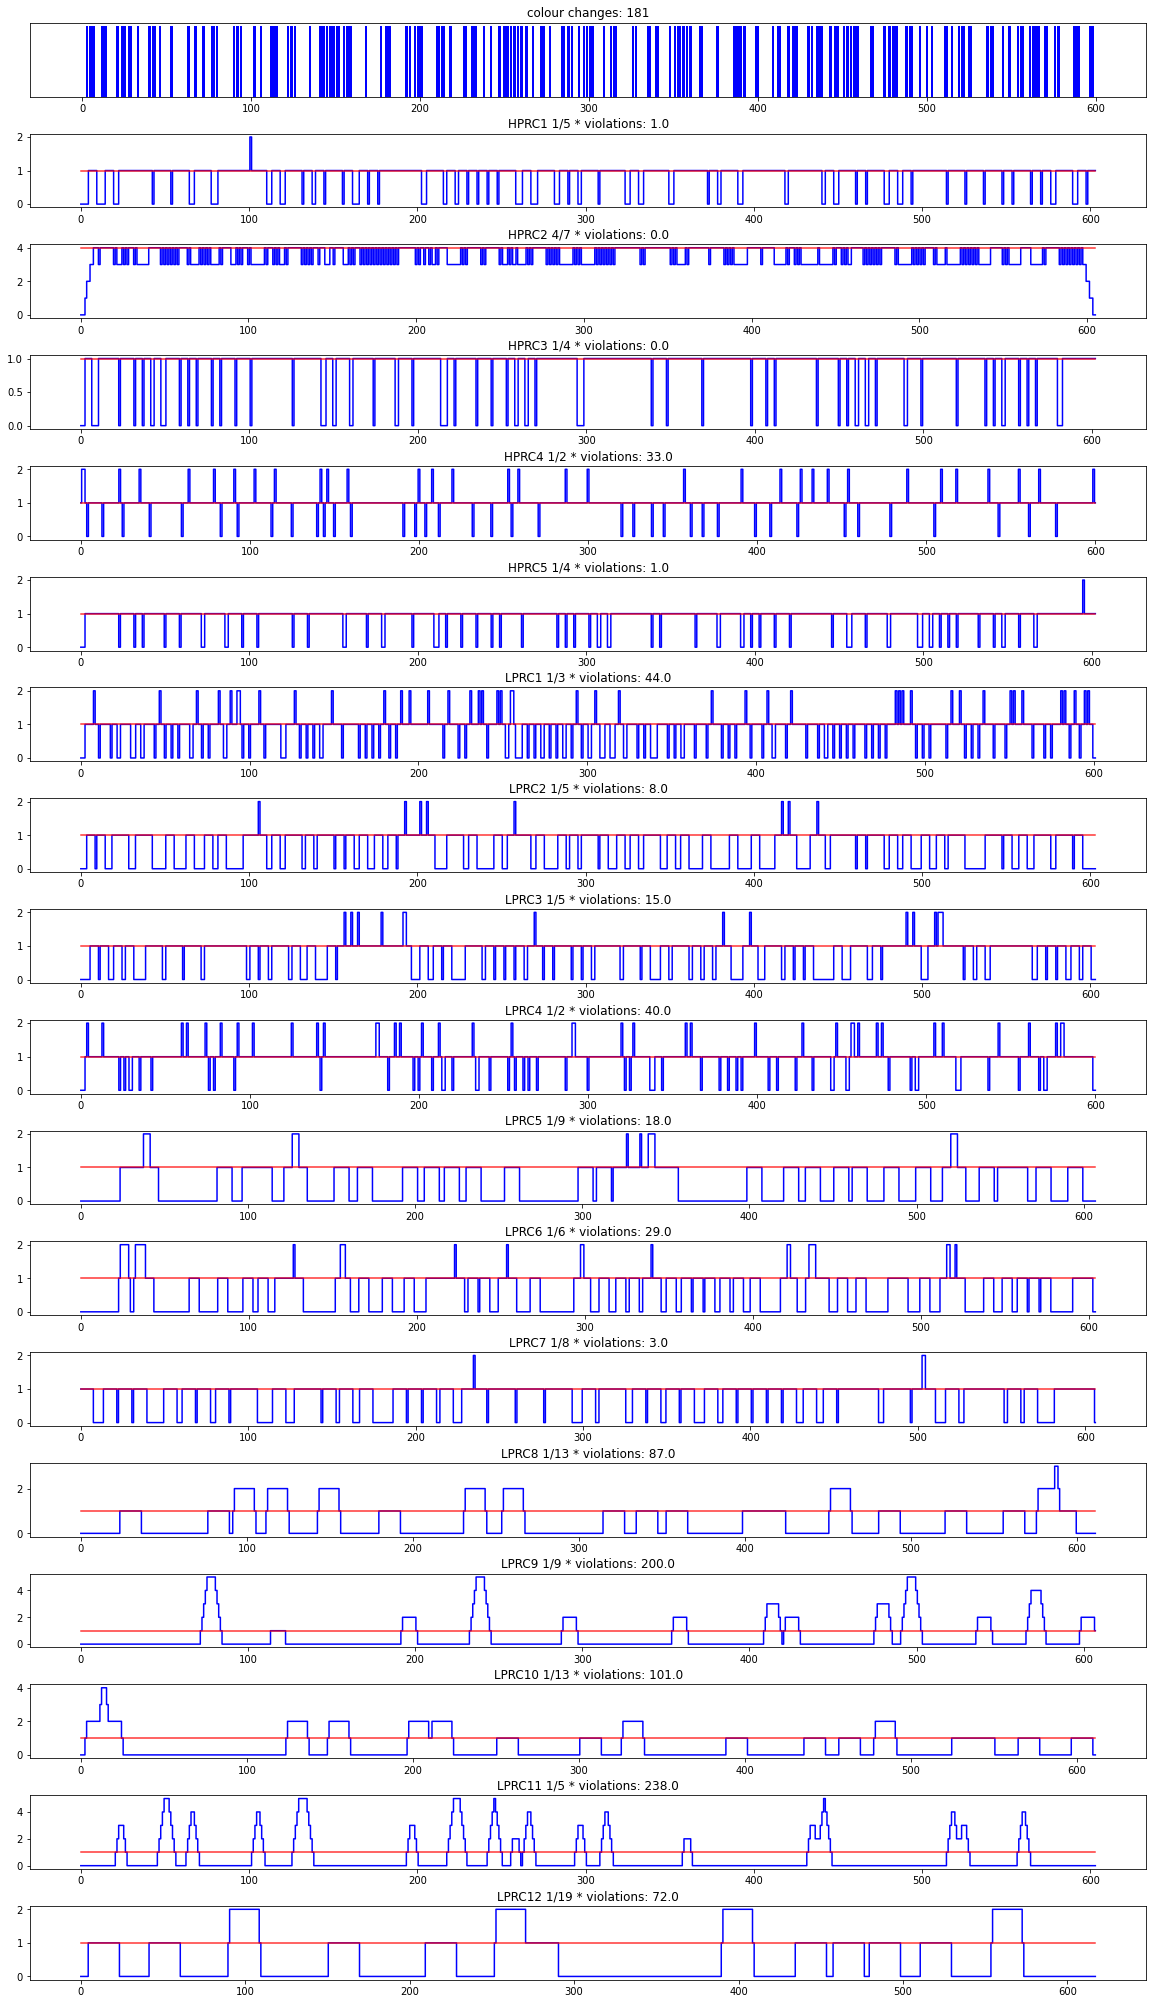

In [13]:
plot_options_and_colours(renault_schedule,sample_instance)

Wir vergleichen die Renault-Lösung mit einer zufälligen Reihenfolge.

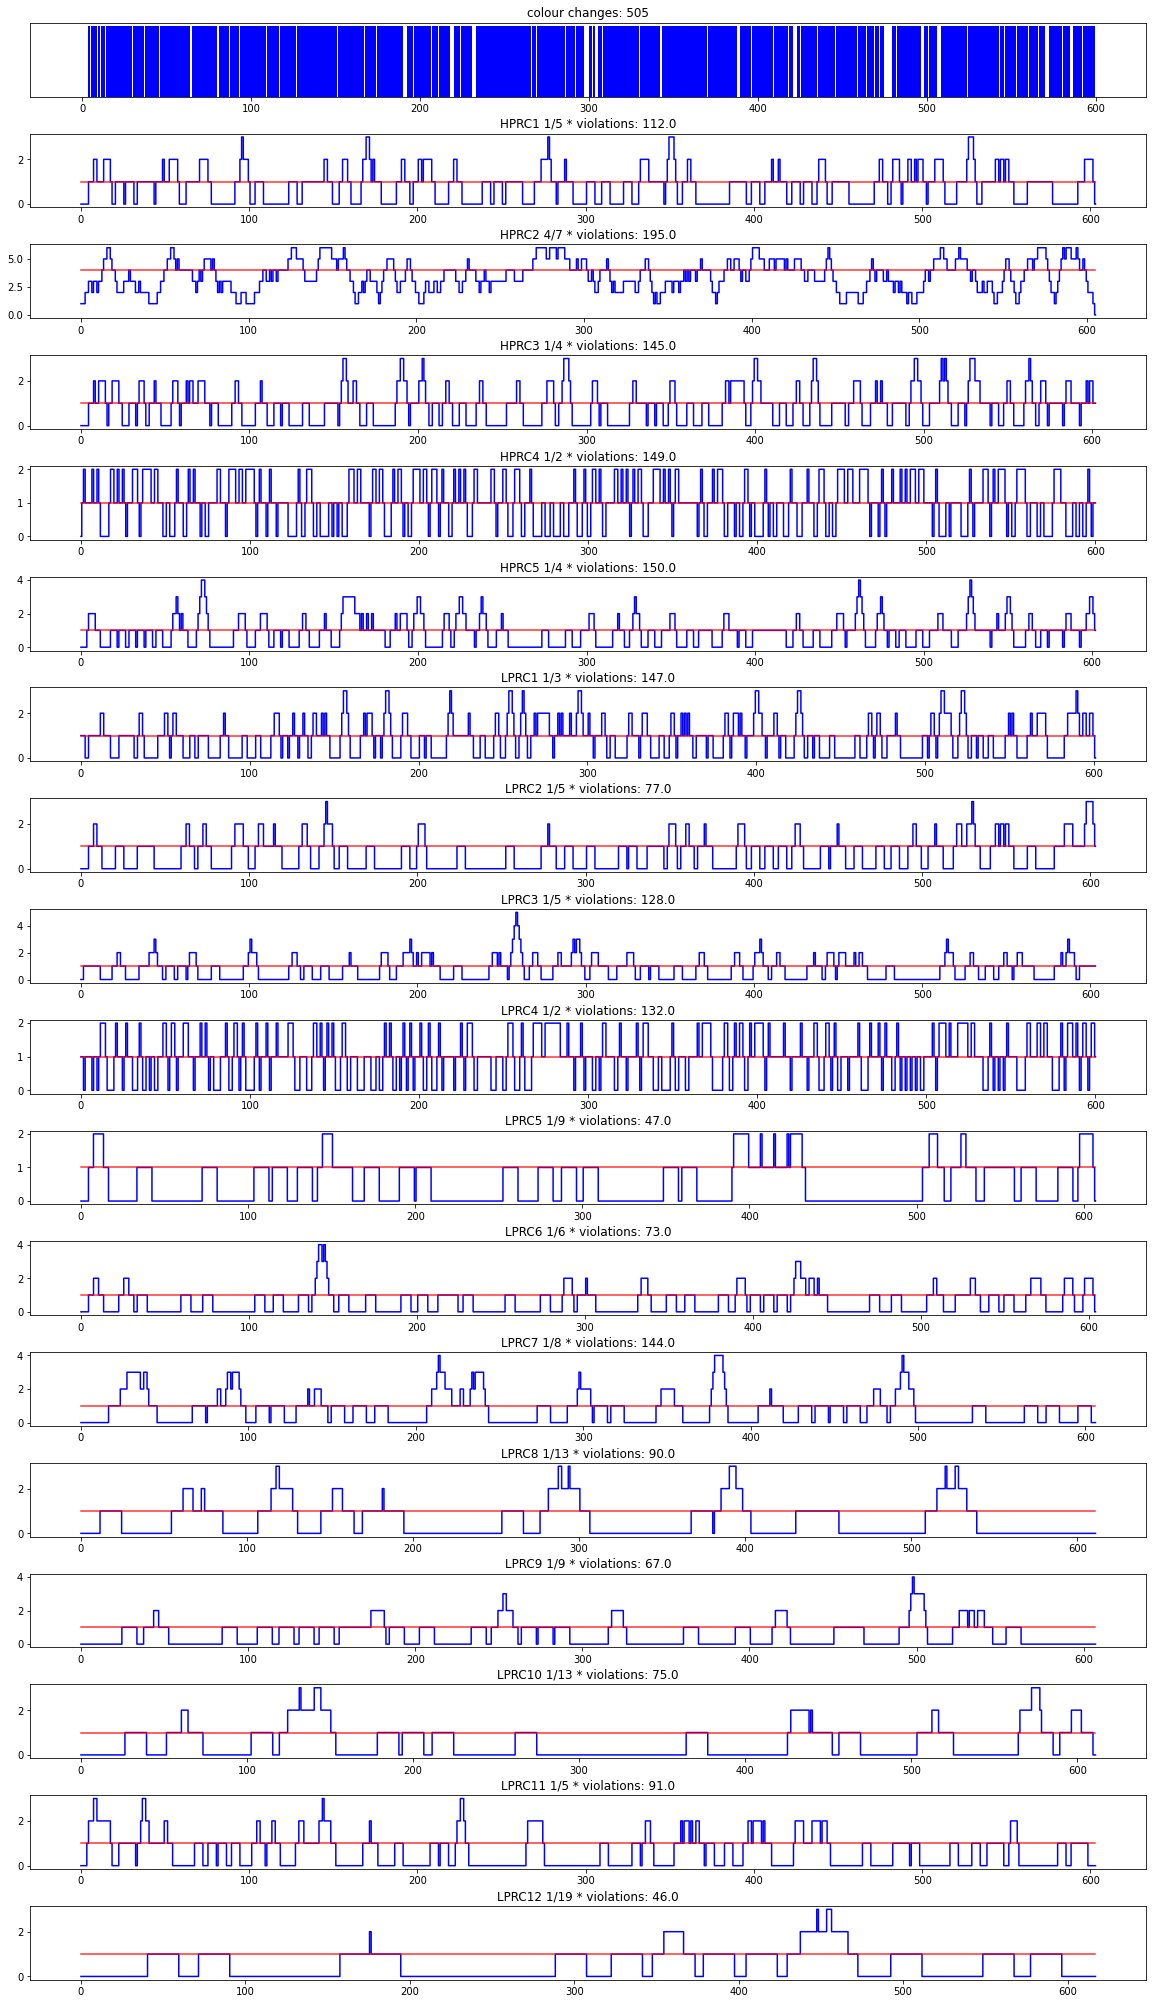

In [14]:
rnd_schedule=np.random.permutation(sample_instance['current_day'])
plot_options_and_colours(rnd_schedule,sample_instance)

In [ ]:
compute_objective(renault_schedule,sample_instance),compute_objective(rnd_schedule,sample_instance)

## 2. Aufgabe: Zufallsreihungen

Bei manchen Problemen reicht es, eine Reihe von Zufallslösungen zu erzeugen und die beste auszuwählen. Implementieren Sie diese Methode und beurteilen Sie die Resultate.

In [ ]:
def best_random_schedule(instance,tries=10):
    best_schedule=None
    best_cost=np.inf
    for _ in range(tries):
        pass
    return best_schedule,best_cost

## 3. Aufgabe: Greedy

Wie könnte ein Greedy-Algorithmus hier aussehen? Vervollständigen Sie die Skizze unten und vergleichen Sie die Ergebnisse mit denen der Zufallsreihungen und dem Renault-Algorithmus. Visualisieren Sie einzelne Lösungen des Greedy-Algorithmus. Was fällt auf?

In [ ]:
def penalty_increase(next_car,partial_schedule,instance):
    pass

def pick_next_greedily(partial_schedule,remaining_cars,instance):
    best_car=None
    best_penalty_increase=np.inf
    for car in remaining_cars:
        increase=penalty_increase(car,partial_schedule,instance)
        if increase<best_penalty_increase:
            best_penalty_increase=increase
            best_car=car
    return best_car

def greedy(instance):
    current_day=instance['current_day']
    remaining_cars=list(np.random.permutation(current_day))
    first_car=remaining_cars.pop()
    partial_schedule=[first_car]
    while len(remaining_cars)>0:
        next_car=pick_next_greedily(partial_schedule,remaining_cars,instance)
        partial_schedule.append(next_car)
        remaining_cars.remove(next_car)
    return partial_schedule